# Fairness Checking: Statistical Parity Constraint Experiment
This notebook uses PuLP to solve the linear program outlined in the "Fairness Checking" document. Here, **we experiment with varying the upper bound constraint on w and see its effects on the objective value.**

In [0]:
!pip install pulp

In [0]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

In [0]:
df = pd.read_csv('/content/drive/My Drive/colab/fairness_checking/predicted_dataset_scores.csv')

In [0]:
df.head(5)

,Unnamed: 0,Unnamed: 0.1,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction_probs,prediction
0,3,0.000693,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.033978,0
1,4,0.000832,1.0,0.294872,0.0,0.0,0.0,0.0,0.368421,1.0,1.0,0.0,1.0,0.822667,1
2,5,0.000970,1.0,0.320513,0.0,0.0,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.223569,0
3,9,0.001664,0.0,0.243590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.069368,0
4,16,0.002634,1.0,0.166667,0.0,0.0,0.0,0.0,0.131579,1.0,1.0,0.0,0.0,0.686681,1


In [0]:
# Our protected variable A is race, and a = 0 or a = 1. 
a = df['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [0]:
# Our pi variables are simply the proportions of a_0 or a_1 
pi_0 = float(len(a_0_indices))/(len(a_0_indices) + len(a_1_indices))
pi_1 = float(len(a_1_indices))/(len(a_0_indices) + len(a_1_indices))

In [0]:
print(pi_0)
print(pi_1)

0.4943181818181818
0.5056818181818182


In [0]:
# Our prediction probability is under 'prediction_probs.' Notice that we use the 
# actual probability of the label, not the label itself.
f_X = df['prediction_probs']
np.asarray(f_X)

array([0.03397822, 0.8226671 , 0.22356904, ..., 0.9929936 , 0.3862658 ,
       0.35257342])

In [0]:
# Check if the dimensions match
print(len(f_X))
print(len(a_0_indices) + (len(a_1_indices)))

1232
1232


## Create Linear Program
We use the PuLP package to create our linear program.

Here, we allow another input for the upper bound on all w's. This must be a number between 0 and 1.

In [0]:
# Input: function f(X), constraint
# Output: (solved) model, weights
def SP_linear_prog(f_X, constraint):
  # Check if constraint is between 0 and 1
  assert(0 < constraint < 1)

  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Statistical Parity Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  # Objective Function
  model += pulp.lpSum(
      [(1./pi_0) * w[index] * f_X[index] for index in a_0_indices] +
      [- (1./pi_1) * w[index] * f_X[index] for index in a_1_indices])
  
  # Constraint that the \sum(w_i * 1{a = 0}) = pi_0
  model += pulp.lpSum([w[index] for index in a_0_indices]) == pi_0
  
  # Constraint that the \sum(w_i * 1{a = 1}) = pi_1
  model += pulp.lpSum([w[index] for index in a_1_indices]) == pi_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1

  # IMPORTANT: Constraint for the w's (experiment with this)
  for weight in w:
    model += w[weight] <= constraint

  # Solve the linear program
  model.solve()
  pulp.LpStatus[model.status]
  
  # Returns the model and the weights
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[i] = w[i].varValue
  return results_dict

In [0]:
# Check if it works
model, weights = SP_linear_prog(f_X, 0.6)

## Experiment with Different Constraints
Iterate over 99 constraints (from 0.01 to 0.99) and see how that affects the objective value.

In [0]:
constraint_granule = 0.01
constraints = []
objective_values = []
dist_weights = []

# Iterate over constraints
for i in range(1, 100):
  model, weights = SP_linear_prog(f_X, constraint_granule * i)
  objective_values.append(pulp.value(model.objective))
  constraints.append(constraint_granule * i)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. SP LP Objective Value')

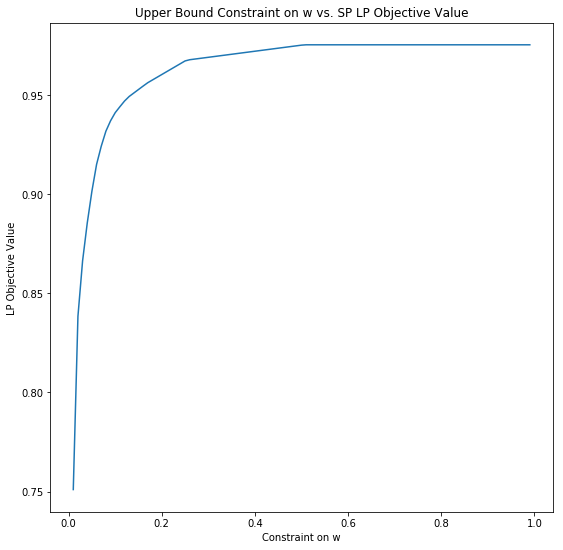

In [0]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(constraints, objective_values)
plt.xlabel('Constraint on w')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. SP LP Objective Value')

In [0]:
weights_dictionary(dist_weights[80])

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 0.0,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0.0,
 86: 0.0,
 87: 0.0,
 88: 0.0,
 89: 0.0,
 90: 0.0,
 91: 0.0,
 92: 0.0,
 93: 0.0,
 94: 0.0,
 95: 0.0,
 96: 0.0,
 97: 0.0,
 98: 0.0,
 99: 0.0,
 100: 0.0,

<BarContainer object of 1232 artists>

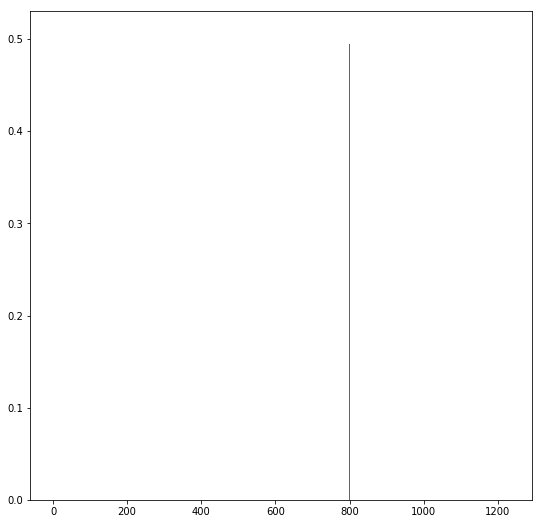

In [0]:
# Plot the distribution of weights
plt.figure(figsize=(9,9))
plt.bar(weights_dictionary(dist_weights[0]).keys(), weights_dictionary(dist_weights[50]).values())

In [0]:
# Save as a CSV
df = pd.DataFrame({'Constraints':constraints, 'SP LP Objective Values':objective_values})
df.head(5)

,Constraints,SP LP Objective Values
0,0.01,0.751011
1,0.02,0.838380
2,0.03,0.866371
3,0.04,0.885456
4,0.05,0.901492


In [0]:
df.to_csv('/content/drive/My Drive/colab/fairness_checking/sp_100_constraints.csv')